# ПРОГНОЗИРОВАНИЕ ВЕРОЯТНОСТИ ОТТОКА ПОЛЬЗОВАТЕЛЕЙ ДЛЯ ФИТНЕС - ЦЕНТРОВ

**Задача проекта** на основании предоставленных данных:
* **файл /datasets/gym_churn.csv**
* **Churn** — факт оттока в текущем месяце

Данные клиента за предыдущий до проверки факта оттока месяц:
* **gender** — пол
* **Near_Location** — проживание или работа в районе, где находится фитнес-центр
* **Partner** — сотрудник компании-партнёра клуба
* **Promo_friends** — факт первоначальной записи в рамках акции «приведи друга»
* **Phone** — наличие контактного телефона
* **Age** — возраст
* **Lifetime** — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* **Contract_period** — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
* **Month_to_end_contract** — срок до окончания текущего действующего абонемента (в месяцах)
* **Group_visits** — факт посещения групповых занятий
* **Avg_class_frequency_total** — средняя частота посещений в неделю за все время с начала действия абонемента
* **Avg_class_frequency_current_month** — средняя частота посещений в неделю за предыдущий месяц
* **Avg_additional_charges_total** — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

1. **составить** ПРОГНОЗ вероятности оттока (на уровне следующего месяца) для каждого клиента
2. **сформировать** типичные ПОРТРЕТЫ клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства
3. **проанализировать** основные ПРИЗНАКИ, наиболее сильно влияющие на отток
4. **сформулировать** основные ВЫВОДЫ и **разработать** РЕКОМЕНДАЦИИ по повышению качества работы с клиентами:
* выделить целевые группы клиентов
* предложить меры по снижению оттока
* определить другие особенности взаимодействия с клиентами

## Загрузка и подотовка данных

**Задача:**
* оценить размер датасета
* оценить наличие пропусков
* оценить типы данных
* оценить наличие аномалий

In [1]:
# загружаем библиотеки,
# подготавливаем рабочее пространство

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 110)

In [2]:
# загружаем данные,
# выводим первичную информацию о данных

data = pd.read_csv('/datasets/gym_churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [3]:
# выводим случайные 5 строк таблицы

display(data.sample(5))

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3624,0,1,1,1,1,6,0,26,145.146109,6.0,0,1.532891,0.696627,1
505,0,0,1,0,1,1,0,31,89.537062,1.0,7,1.626797,1.572631,0
1445,0,1,1,1,1,6,1,32,48.696958,3.0,4,1.231661,1.364138,0
2128,0,1,1,1,1,6,1,31,255.117543,6.0,3,2.687575,2.638183,0
1614,1,1,1,1,1,12,0,30,48.160030,10.0,3,2.919274,2.823736,0


In [4]:
# приводим названия столбцов к нижнему регистру

data.columns = map(str.lower, data.columns) 
print(data.columns)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')


In [5]:
# проверяем минимальные и максимальные значения в столбцах

columns = data.columns
features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn']
for column in columns:
    min = data[column].min()
    max = data[column].max()
    print(min, max)

0 1
0 1
0 1
0 1
0 1
1 12
0 1
18 41
0.1482047884566242 552.5907403868798
1.0 12.0
0 31
0.0 6.02366847599591
0.0 6.146782880452392
0 1


### Выводы

* Предоставленный к исследованию датасет содержит 4 000 записей и 14 колонок
* Данные не содержат пропущенных значений
* Формат данных соответствует ожидаемому
* Все признаки имеют числовой тип
* Целевая переменная не имеет временной структуры
* Минимальные и максимальные значения также соответствуют ожидаемым
* столбцы: 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn' имеют бинарный характер данных (0 / 1)
* столбцы: 'contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month' имеют не бинарный характер данных
* В качестве преобразования названия столбцов приведены к нижнему регистру

## EDA исследовательский анализ данных

**Задача**: 
* изучить характер распределения данных
* изучить силу взаимосвязей между данными / признаками
* сделать предположение какие признаки станут ключевыми для модели, а какими можно и нужно пренебречь

###  Характер распределения данных в рамках датасета

In [6]:
# создаем список признаков с бинарными значениями 0_1

features_binar = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']

# создаем список признаков с небинарными значениями

features_non_binar = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract'\
                      , 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

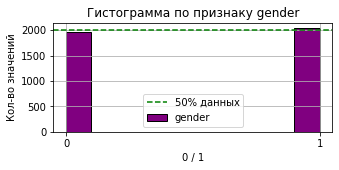

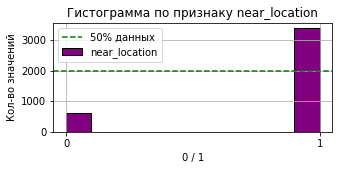

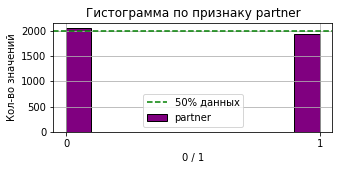

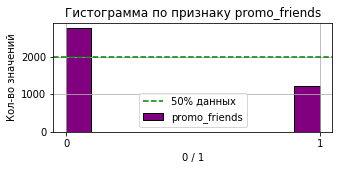

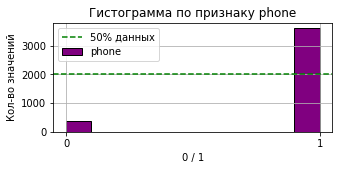

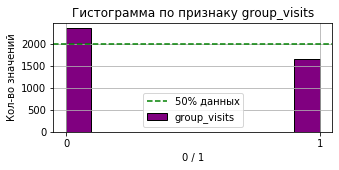

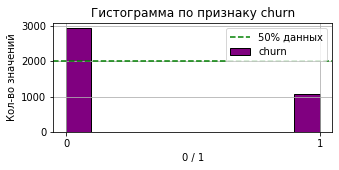

In [7]:
# строим гистограммы для признаков с бинарными значениями

for column in features_binar:
    data[column].plot(kind='hist', figsize=(5, 2), grid=True, edgecolor = 'black', fill = True, facecolor = 'purple')
    plt.title('Гистограмма по признаку ' + column)
    plt.xlabel('0 / 1')
    plt.ylabel('Кол-во значений')
    plt.axhline(y= 2000, color='green', linestyle='--', label='50% данных')
    plt.xticks([0,1])
    plt.legend()
    plt.show()

**Выводы по графикам:**

* Признаки **phone** и **near_location** имеют абсолютный перевес данных в пользу значения "да, имеется", приближаясь к 100%
* Данные по признакам **partner** и **gender** поделились приблизительно пополам
* Данные по признаку **churn** на 75% сместились к значению "нет, не прервал контракт"
* Данные по признаку **promo_friends** на 69% сместились к значению "нет, не относится к промо друзьям"
* Данные по признаку **group_visits** yf 63% сместились к значению "нет, не посещает"

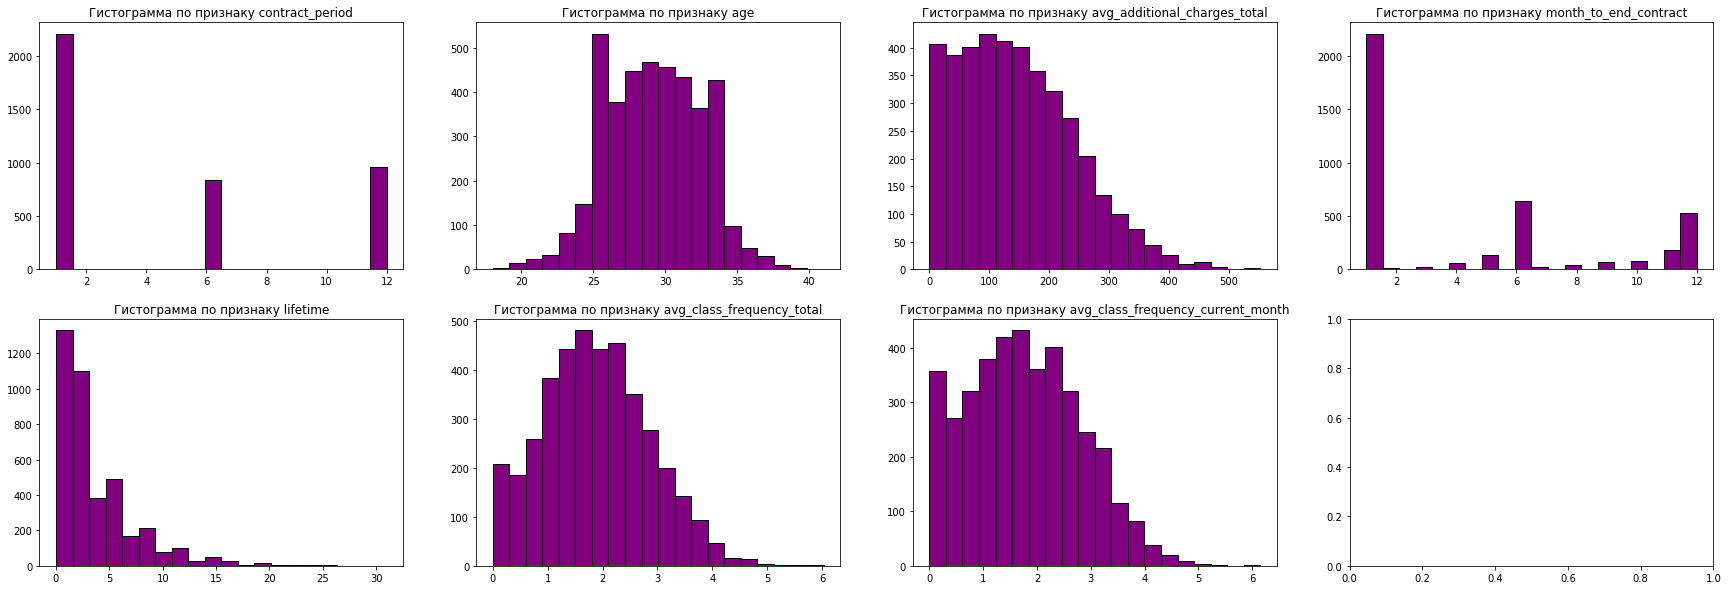

In [8]:
# строим гистограммы для признаков с небинарными значениями

fig, axes = plt.subplots(2, 4)
fig.set_size_inches(30, 10)
axes = axes.ravel()
i = 0
for column in features_non_binar:
    axes[i].hist(data[column], edgecolor = 'black', fill = True, facecolor = 'purple', bins=20)
    axes[i].set(title = 'Гистограмма по признаку ' + column)
    i+=1
fig.show()

In [9]:
# выводим стат данные по небинарным признакам с ненормальным распределением

display(data[['avg_additional_charges_total', 'month_to_end_contract'\
                      , 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']].describe().T)

,count,mean,std,min,25%,50%,75%,max
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
avg_class_frequency_total,4000.0,1.879020,0.972245,0.000000,1.180875,1.832768,2.536078,6.023668
avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.000000,0.963003,1.719574,2.510336,6.146783


**Выводы по графикам и стат данным:**

* Распределение данных небинарных признаков имеет логичный характер и не имеет аномалий
* У переменных разные по величине стандартные отклонения, что потребует стандартизации данных при обучении моделей.
* Данные параметра contract_period разбиты на 3 группы: 56% клиентов имеют месячный абонемент, 20% клиентов имют полугодовой абонемент и порядка 24% клиентов имеют годовой абонемент
* Данные параметра age имеют нормальное распределение в диапазоне от 18 лет до 41 года
* В среднем клиент приносит клубу дополнительно (параметр avg_additional_charges_total) 147 рублей с максимальным значением 553 рубля.
* 75% клиентов имеют срок до окончания текущего абонемента (параметр month_to_end_contract) менее 6 месяцев.
* Средняя "продолжительность жизни" клиента (параметр lifetime) составляет 3 - 4 месяца
* В среднем клиент посещает зал 1,88 раза в месяц (параметр avg_class_frequency_total)
* В текущем месяце средняя посещаемость составила 1,77 раз (параметр avg_class_frequency_current_month)

### Характер распределения данных признаков, сгрупированных по целевой переменной churn

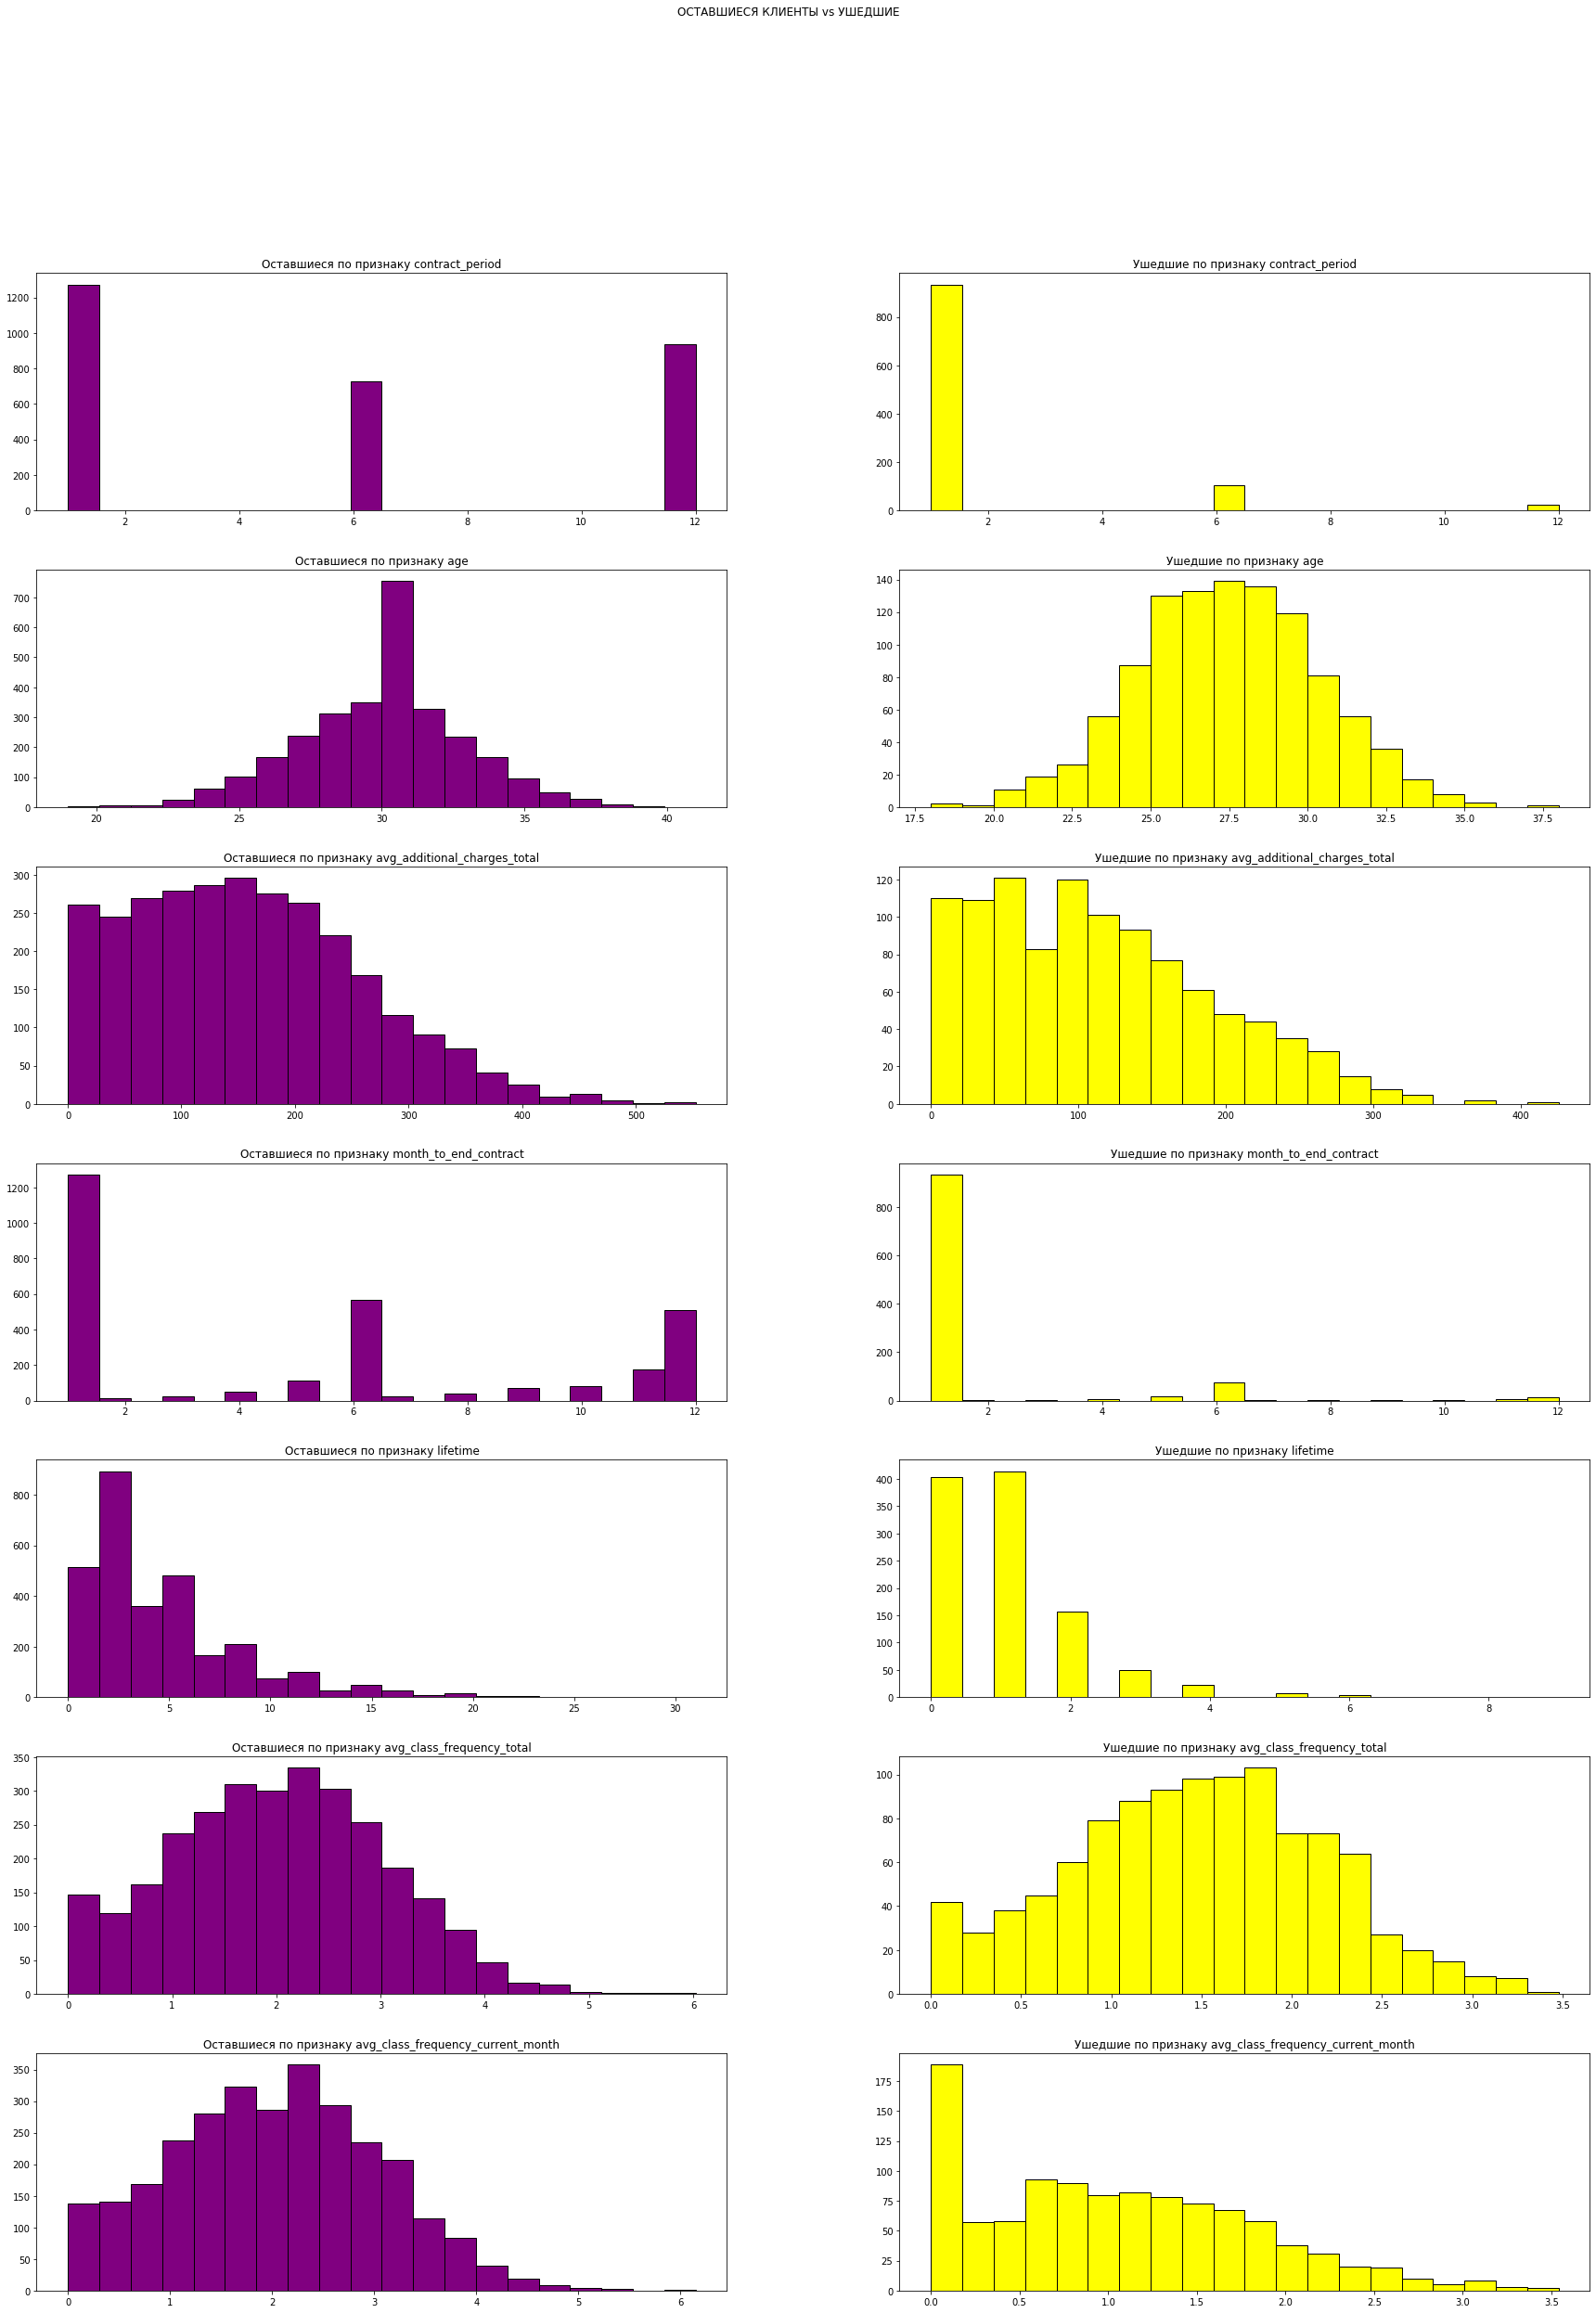

In [10]:
# строим гистограммы по небинарным признакам в разрезе целевой переменной

fig, axes = plt.subplots(7, 2)
fig.set_size_inches(30, 40)
axes = axes.ravel()
i = 0
for column in features_non_binar:
    axes[i].hist(data[data['churn'] == 0][column], edgecolor = 'black', fill = True, facecolor = 'purple', bins=20)
    axes[i].set(title = 'Оставшиеся по признаку ' + column)
    i+=1
    axes[i].hist(data[data['churn'] == 1][column], edgecolor = 'black', fill = True, facecolor = 'yellow', bins=20)
    axes[i].set(title = 'Ушедшие по признаку ' + column)
    i+=1
plt.suptitle("ОСТАВШИЕСЯ КЛИЕНТЫ vs УШЕДШИЕ")
plt.subplots_adjust(hspace=0.25, wspace=0.25)
fig.show()

In [11]:
# проверяем средние значения небинарных признаков в разрезе целевой переменной
display(data.groupby('churn').agg('mean')\
        .drop(['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits'], axis=1)\
        .T\
        .rename(columns={0:'остались', 1:'ушли'})\
        .round(2))

churn,остались,ушли
contract_period,5.75,1.73
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66
lifetime,4.71,0.99
avg_class_frequency_total,2.02,1.47
avg_class_frequency_current_month,2.03,1.04


**Выводы по графикам и данным:**
* Средняя длительность действующего абонемента у ушедших составляет 1,73 месяца, у оставшихся - 5,75. Среди ушедших доминируют владельцы месячных абонементов.
* Средний возраст разнится не существенно - 27 лет у ушедших и 30 лет у оставшихся. Основная масса ушедших находится в диапазоне 25 - 30 лет.
* Сумма дополнительных покупок у ушедших в среднем ниже на 27% меньше, чем у оставшихся. 
* Распределение средних значений параметра month_to_end_contract явно перекликается с распределением средних значений параметра contract_period и lifetime
* Средня посещаемость ушедших на 27% ниже, чем оставшихся
* Посещаемость текущего месяца у ушедних ниже на 49%

<Figure size 432x288 with 0 Axes>

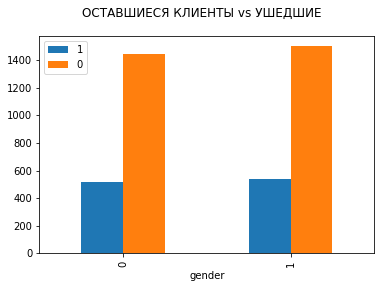

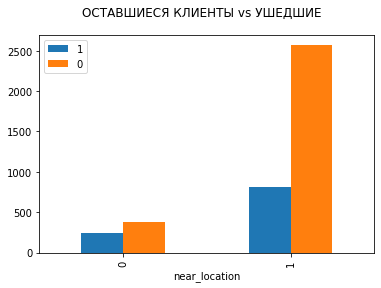

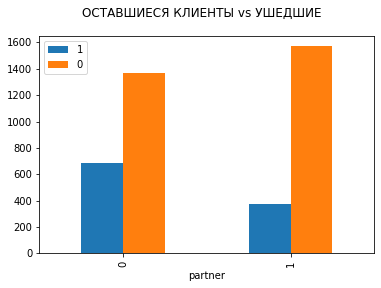

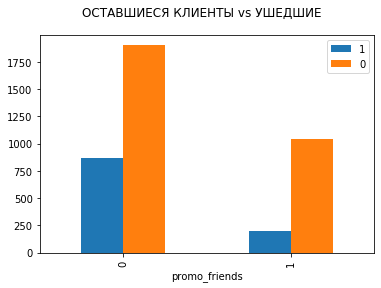

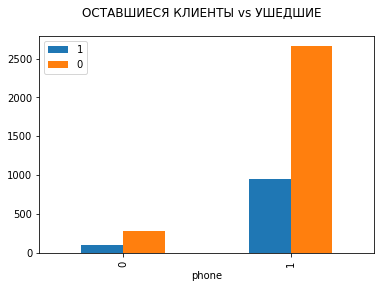

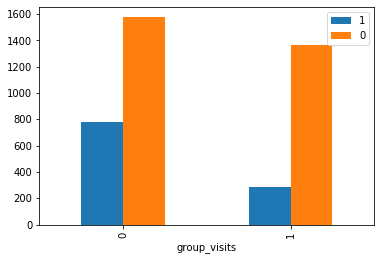

In [12]:
# строим столбчатые диаграммы по бинарным признакам
# в разрезе целевой переменной
features_binar_no_churn = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
for column in features_binar_no_churn:
    x = data.groupby(column)['churn'].agg('sum')
    y = data.groupby(column)['churn'].agg('count') - data.groupby(column)['churn'].agg('sum')
    s = {'1':x, '0':y}
    df = pd.DataFrame(s)
    plt.suptitle("ОСТАВШИЕСЯ КЛИЕНТЫ vs УШЕДШИЕ")
    df.plot(kind='bar')

**Выводы по графикам:**

* В гендерном признаке ушедшие и оставшиеся распределились приблизительно одинаково: в каждом из полов произел отток порядка 35%.
* Удаленность проживания от зала свидетельствует, что больше уходят те, кто живет не рядом с залом: 60% ушедших среди проживающих удаленно и порядка 30% среди проживающих рядом.
* В партнерских программах ушедших также сравнительно меньше, чем в непартнерских: из партнерских программ произошел отток порядка 26%, тогда как из непартнерских порядка 50%.
* В промо друзьях отток меньше среди друзей: 20% vs 47% среди не друзей.
* Наличие телефона скорее всего является слабым признаком, т.к. значение этого параметра в принципе близко к 100%.
* По параметру групповых занятий больше отток средих тех, кто их не посещает: порядка 50% vs 15% среди тех, кто посещает. 

### Выявление корреляции между параметрами

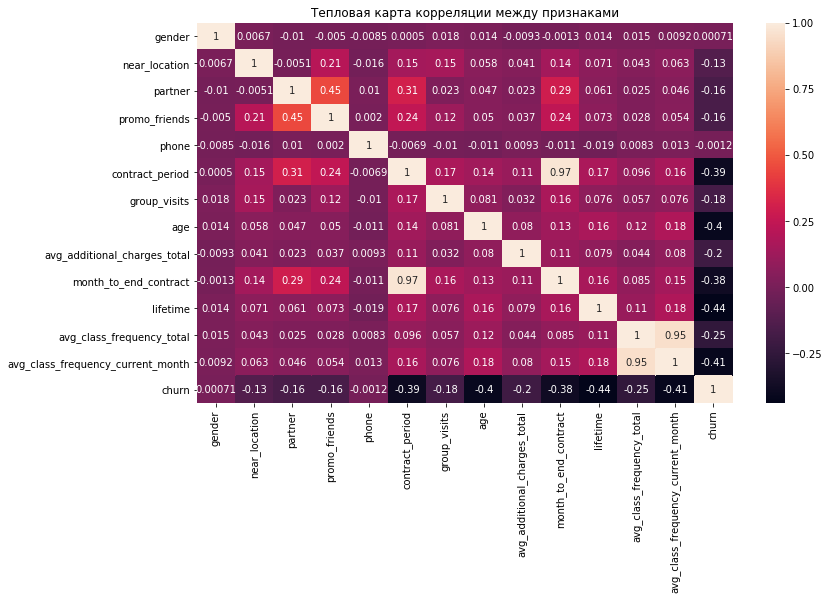

In [13]:
# строим матрицу корреляций и тепловую карту

cm = data.corr()
plt.figure(figsize=(12, 7))
sns.heatmap(data = cm, annot = True)
plt.title('Тепловая карта корреляции между признаками')
plt.show()

**Выводы по графику:**

Тепловая карта матрицы корреляции параметров подтверждает высокий уровень связи = 0.97 между параметрами month_to_end_contract и contract_period. Также высокое значение = 0.95 поллучила пара параметров avg_class_frequency_total и avg_class_frequency_current_month, что скорее всего объясняется схожестью данных.

### Выводы

* В ходе исследовательского анализа данных было проанализировано 13 параметров, которые могут влиять на целевую переменную.
* Аномалий в данных не выявлено.
* Распределения носят нормальный или логичный характер.
* Между 2-мя парами параметров выявлены достаточно сильные взаимосвязи, что может привести к эффекту мультиколлинеарности.
* Одними из ведущих параметров могут стать contract_period и avg_class_frequency_current_month, наиболее очевидно определяющие группу ушедших.
* К слабым параметрам можно отнести наличие телефона, так как его общее значение близко к 100%, и гендерный признак, в котором ушедшие распределились зеркально.
* Чаще отток клиентов происходит среди: клиентов, которые проживают удаленно от зала, редко ходят на групповые занятия, не являются промо друзьями и не относятся к партнерам.

## Построение модели прогнозирования оттока клиентов

Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

### Формирование валидационного множества и стандартизация

In [14]:
# делим данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis=1)
y = data['churn']
 
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [15]:
# стандартизируем данные

# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)
 
# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

#### Выводы
* Так как целевая переменная churn не имеет временной привязки валидационное множество сформировано случайным образом в пропорции 20% х 80%.
* Данные обучающей и валидационной выборок стандартизированы.

### Обучение модели на обучающей выборке и прогноз

#### логистическая регрессия

In [16]:
# задае алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0, solver='liblinear')

# обучаем модель
lr_model.fit(X_train_st, y_train)

# делаем прогноз
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# выводим метрики
print("Предсказанный моделью отток:", lr_predictions.sum())

Предсказанный моделью отток: 192


#### случайный лес

In [17]:
# зададим алгоритм для модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0 )

# обучаем модель случайного леса
rf_model.fit(X_train_st, y_train)

# делаем прогноз
rf_predictions = rf_model.predict(X_test_st)

In [18]:
print("Предсказанный моделью отток:", rf_predictions.sum())

Предсказанный моделью отток: 192


In [19]:
# выводим значения весов признаков, присвоенные моделью
importances = rf_model.feature_importances_
feature_list = list(X_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
display(feature_results)

,feature,importance
0,lifetime,0.276499
1,avg_class_frequency_current_month,0.180170
2,avg_class_frequency_total,0.129883
3,age,0.119129
4,avg_additional_charges_total,0.091473
5,month_to_end_contract,0.068855
6,contract_period,0.065964
7,group_visits,0.015652
8,gender,0.012425
9,partner,0.012285


### Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке

In [20]:
# выводим метрики для полученного прогноза по модели логистической регрессии
print('Метрики при автоматическом прогнозе по модели логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))

Метрики при автоматическом прогнозе по модели логистической регрессии
Accuracy: 0.92
Precision: 0.85
Recall: 0.83


In [21]:
# выводим метрики для полученного прогноза по модели случайного леса
print('Метрики при автоматическом прогнозе по модели случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики при автоматическом прогнозе по модели случайного леса
Accuracy: 0.92
Precision: 0.84
Recall: 0.81


#### Выводы

Сравнение метрик обученных моделей показывает, что:
* **ACCURACY** - логистическая регрессия и случайный лес дали одинаковые доли правильных ответов = 92%. Обе модели предсказали на тестовой выборке одинаковое количество склонных к уходу клиентов = 192

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$

* **PRECISION** - доля правильно предсказанных положительных объектов среди всех объектов, предсказанных положительным классом, у логистической регрессии оказалась выше, чем у случайного леса: 85% vs 84%.

$$Precision = \frac{TP}{TP+FP}$$

* **RECALL** - доля правильно найденных положительных объектов среди всех объектов положительного класса также выше у логистической регрессии: 83% vs 81%

$$Precision = \frac{TP}{TP+FN}$$

* В качестве решения для прогноза рекомендуется приянть модель логистической регрессии.

## Кластеризация клиентов

### Матрица расстояний

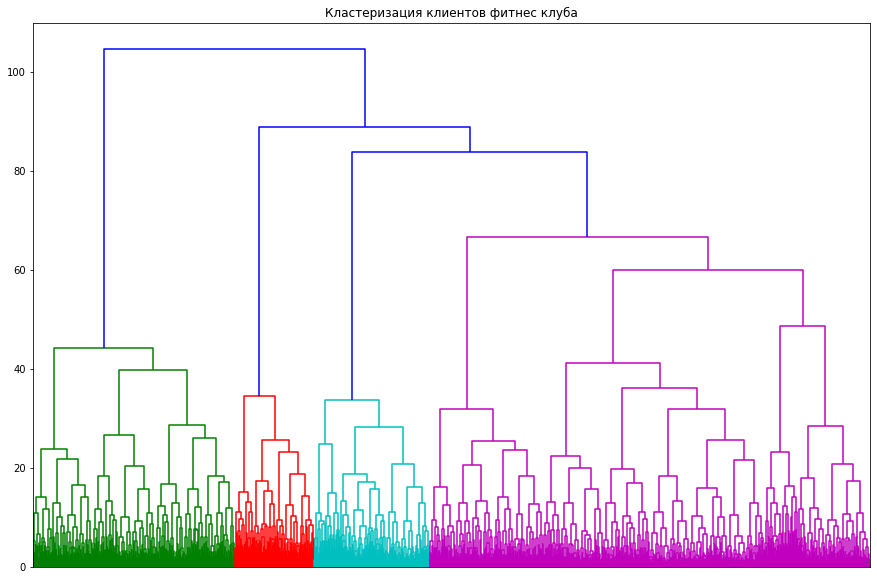

In [22]:
# стандартизируем весь набор данных по параметрам
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# создаем таблицу связок между объектами
linked = linkage(X_sc, method = 'ward')

# создаем дендрограмму
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top', no_labels = True)
plt.title('Кластеризация клиентов фитнес клуба')
plt.show()

**Выводы по графику:**

Визуализация связей позволяет выделить 5 кластеров для дальнейшего изучения.

### Кластеризация клиентов на основании алгоритма K-Means

In [23]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 1)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)
 
# сохраняем метки кластера в поле датасета
data['cluster_km'] = labels

In [24]:
# выводим статистику по количеству ушедших и оставшихся клиентов в кластерах

churn = data.groupby(['cluster_km', 'churn']).agg({'phone':'count'})\
       .reset_index()\
        .pivot_table(index='cluster_km', columns = 'churn', values='phone', aggfunc=('min'))\
       .rename(columns={0:'остались', 1:"ушли"})
churn['всего'] = churn['остались'] + churn['ушли']
churn['доля ушедших'] = (churn['ушли'] / churn['всего'] * 100).round()
display(churn)

churn,остались,ушли,всего,доля ушедших
cluster_km,,,,
0,297,224,521,43.0
1,974,553,1527,36.0
2,903,18,921,2.0
3,482,163,645,25.0
4,283,103,386,27.0


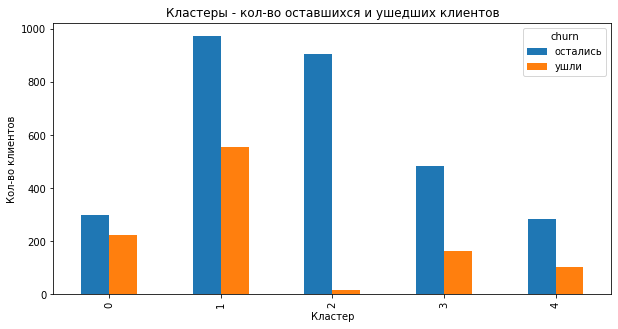

In [25]:
# строим столбчатую диаграмму по количеству ушедших и оставшихся клиентов в кластерах

churn[['остались', 'ушли']].plot(kind='bar', figsize=(10, 5), title=('Кластеры - кол-во оставшихся и ушедших клиентов'))
plt.xlabel("Кластер")
plt.ylabel("Кол-во клиентов")
plt.show()

**Выводы по графикам и данным:**

* Кластеризация клиентов методом K-means выделила 5 групп с разным составом:
>
> 1 527 клиентов - 1 кластер
>
> 921 клиент - 2 кластер
>
> 645 клиентов - 3 кластер
>
> 521 клиент - 0 кластер
>
> 386 клиентов - 4 кластер
>
* Зону **риска** определяет кластер **№ 0**, в котором количество ушедших клиентов составило **43%**
* Наиболее **лояльным** является кластер **№ 2**, в котором отток составил всего **2%**
* Отток в самом **многочисленном** кластере **№ 1**, в который вошло 1 527 клиентов (38% от общего), составил **36%**

In [26]:
# выводим статистику по средним значениям небинарных признаков по кластерам

features_non_binar_mean = data.groupby('cluster_km')\
[['contract_period', 'age', 'month_to_end_contract', 'avg_additional_charges_total'\
  , 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']]\
.agg('mean').T

display(features_non_binar_mean)

cluster_km,0,1,2,3,4
contract_period,2.343570,2.056974,11.511401,2.972093,4.777202
age,28.579655,28.918140,29.964169,29.120930,29.297927
month_to_end_contract,2.197697,1.963982,10.457112,2.778295,4.466321
avg_additional_charges_total,136.561586,141.863877,166.325823,141.317434,144.208179
lifetime,2.905950,3.309758,4.829533,3.662016,3.940415
avg_class_frequency_total,1.738534,1.808608,2.116481,1.834968,1.854211
avg_class_frequency_current_month,1.562870,1.655857,2.109532,1.731981,1.723967


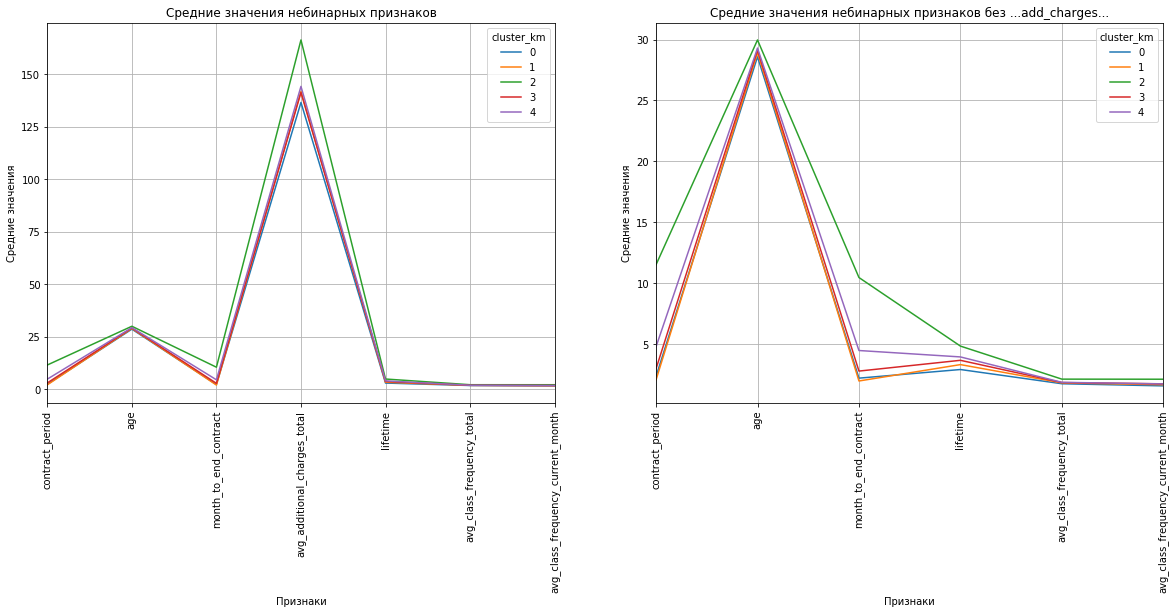

In [27]:
# создаем график средних значений небинарных признаков
plt.figure(figsize=(20, 7)) 
ax1 = plt.subplot(1, 2, 1)
features_non_binar_mean.plot(kind='line',grid=True, title=('Средние значения небинарных признаков'), ax=ax1)
plt.xticks(rotation=90)
plt.xlabel("Признаки")
plt.ylabel('Средние значения')
ax2 = plt.subplot(1, 2, 2)
data.groupby('cluster_km')\
[['contract_period', 'age', 'month_to_end_contract'\
  , 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']]\
.agg('mean').T.plot(kind='line', grid=True, title=('Средние значения небинарных признаков без ...add_charges...'), ax=ax2)
plt.xlabel("Признаки")
plt.ylabel('Средние значения')
plt.xticks(rotation=90)
plt.show()

**Выводы по графикам и данным:**

* Самый лояльный кластер **№ 2** практически по всем небинарным признакам показал более высокие результаты по сравнению с остальныи
* Небинарные признаки,в которых слабо различимы отличия между кластерами в средних значениях:
>
> age - возраст
>
> avg_class_frequency_total - кол-во посещений занятий в среднем всего
>
> avg_class_frequency_total_current_month - кол-во посещений занятий в среднем в текущем месяце
>
* Кластер риска **№ 0** имеет самые низкие среди остальных кластеров показатели по параметрам:
>
> age
>
> avg_additional_charges_total
>
> lifetime
>
> avg_class_frequency_tota
>
> 
> avg_class_frequency_current_month

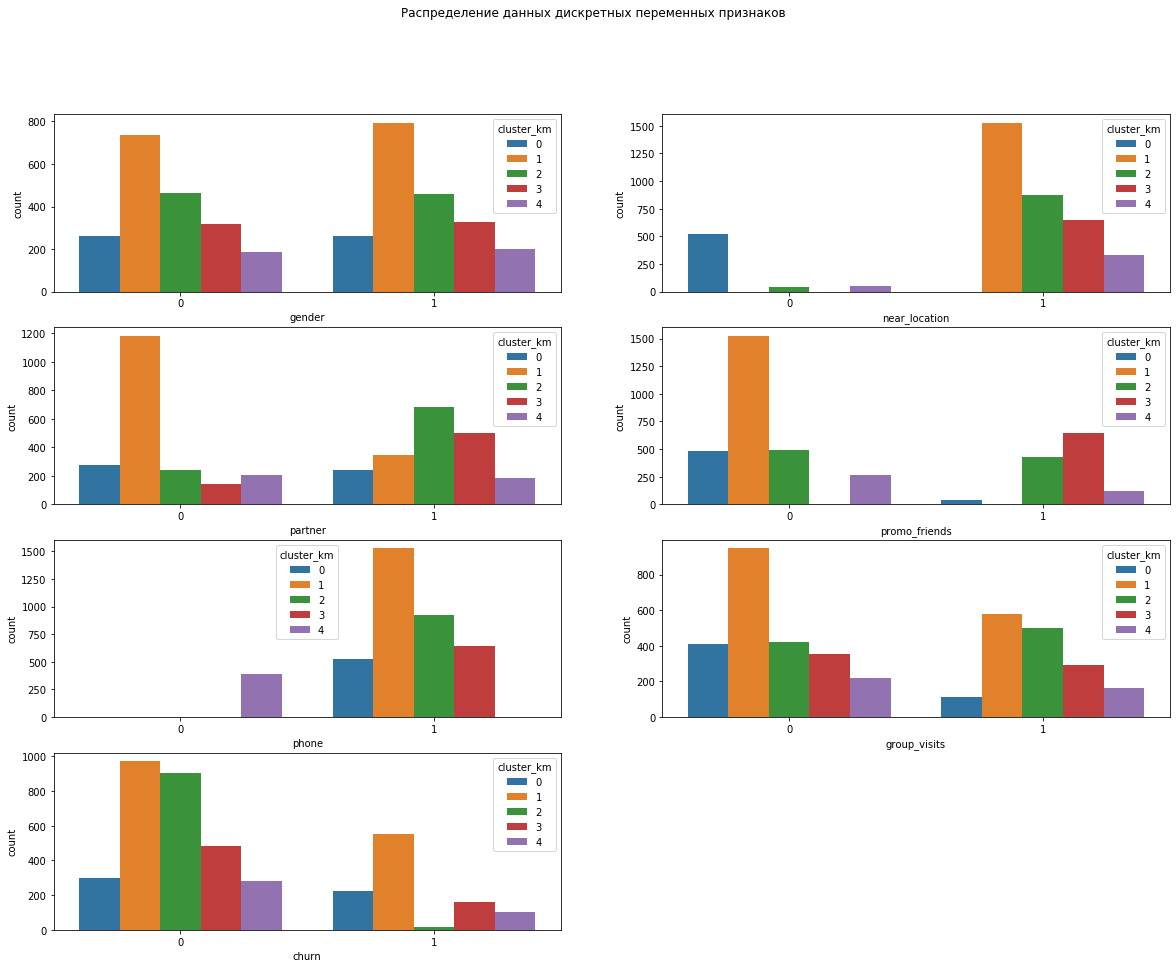

In [28]:
# строим столбчатые диаграммы для дискретных пременных признаков по кластерам

fig, axes = plt.subplots(4,2)
fig.set_size_inches(20, 15)
axes = axes.ravel()
i = 0
for column in features_binar:
    sns.countplot(data = data, x = column, hue = 'cluster_km', ax = axes[i])
    i+=1
fig.delaxes(axes[7])
fig.suptitle('Распределение данных дискретных переменных признаков')
plt.show()

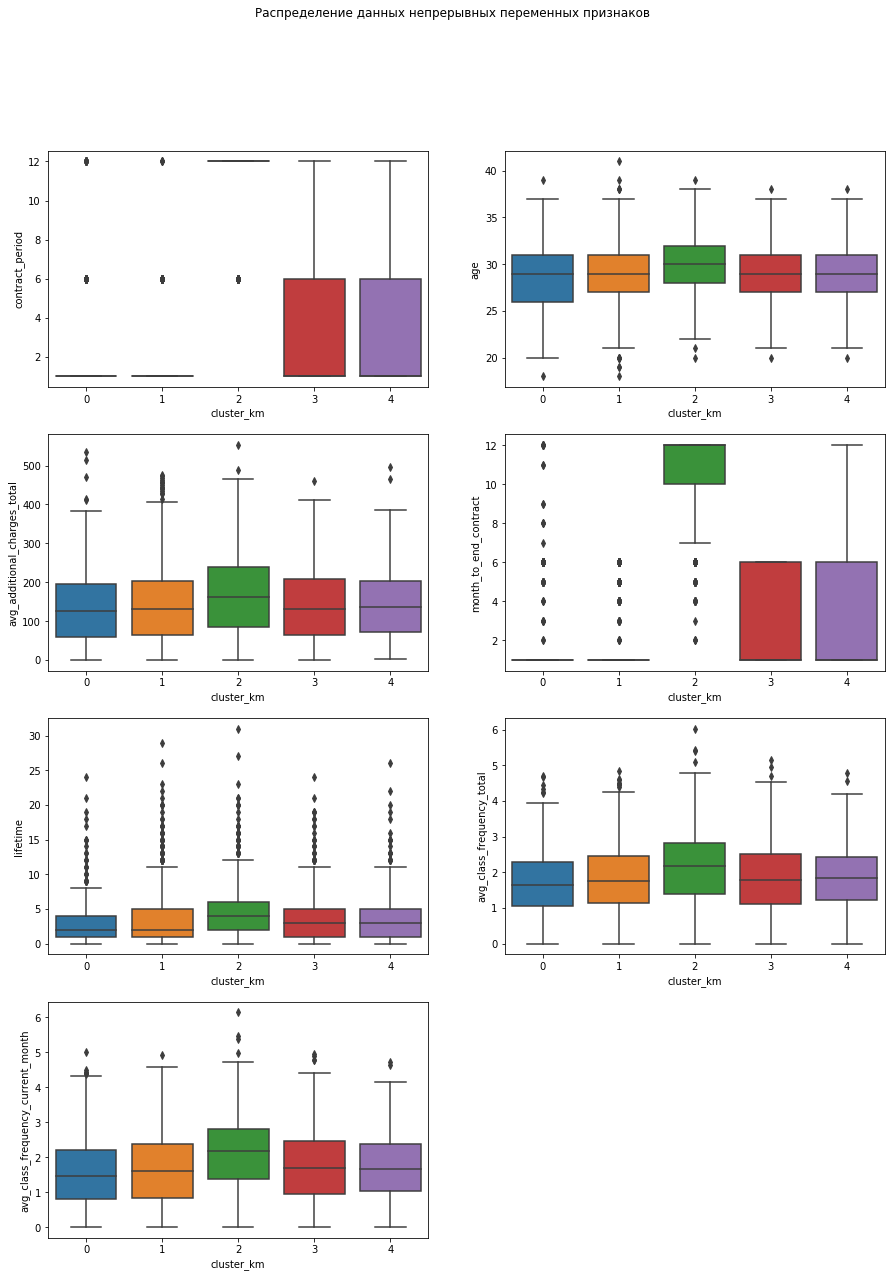

In [29]:
# строим диаграммы размаха для непрерывных пременных признаков по кластерам

fig, axes = plt.subplots(4,2)
fig.set_size_inches(15, 20)
axes = axes.ravel()
i = 0
for column in features_non_binar:
    sns.boxplot(x ='cluster_km',y = column, data = data, ax = axes[i])
    i+=1
fig.delaxes(axes[7])
fig.suptitle('Распределение данных непрерывных переменных признаков')
plt.show()

**Выводы по графикам:**

* **gender** - распределение клиентов по гендерному признаку произошло между кластерами приблизительно **в равных долях**
* **near_location** - клиенты, проживающие удаленно от фитнес клуба, попали в кластер риска **№ 0**
* **partner** - большая часть клиентов, не участвующих в парнерской программе, попала в самый многочисленный кластер **№ 1**, в котором 36% оттока. Также в категорию "не партнеров" попали клиенты кластера риска **№ 0**.
* **promo_friends** - распределение данных в этом параметре идентично распределению в параметре **partner**
* **phone** - все клиенты, не предоставившие номер телефона, отнесены моделью к кластеру **№ 4**, с оттоком 27%
* **contract_period** - контрактный период представлен 3-мя группами: 1 месяц, 6 месяцев и 12 месяцев. Группа с периодом 1 месяц является самой многочисленной, основную ее часть составляют клиенты из кластера **№ 1**, с оттоком 36%, также в нее попали 77% кластера риска **№ 0**. Лояльный кластер **№ 2** с оттоком 2% поделился между между группами 6 месяцев и 12 месяцев с большим перевесом в пользу последней.
* **group_visits** - клиентов, не посещающих групповые занятия больше, чем посещающих. Половину непосещяющих составили клиенты кластера **№ 1** с отткомо 36%. Самая большая доля среди посещающих пришласть на лояльный кластер **№ 2** с оттоком 2%.
* **age** - данные по возрасту распределились между кластерами нормально или близко к нормальному.
* **avg_additional_charges_total** - распределение данных по признаку общих дополнительных оплат во всех кластерах имеет ассиметричный правостороннний характер, данные скошены вправо. Аномальных признаков нет.
* **month_to_end_contract** - клиенты кластера риска **№ 0** оказались в группе 1 месяца до окончания контракта, клиенты лояльного кластера **№ 2** распределились между 6 и 12 месяцами с перевесом в пользу 12, что коррелирует с распределением данных по параметру **contract_period**. 
* **lifetime** - распределение данных по признаку во всех кластерах имеет ассиметричный правостороннний характер, данные скошены вправо. Аномальных признаков нет. 
* **avg_class_frequency_total** - распределение данных по признаку во всех кластерах имеет ассиметричный правостороннний характер, данные скошены вправо. Большая скошенность просматривается у лояльного кластера **№ 2**.
* **avg_class_frequency_current_month** - характер распределения данных повторяет признак avg_class_frequency_total.
* **churn** - большую часть оттока составляют клиенты из самого многочисленного кластера **№ 1**. Также большую часть составляют клиенты из кластера риска **№ 0**.

## ВЫВОДЫ И РЕКОМЕНДАЦИИ ПО РАБОТЕ С КЛИЕНТАМИ

Проведенный анализ информации по признакам в том числе с применением методов машинного обучения и кластеризации  в разрезе всех данных, а также в разрезе выявленных кластеров позволяет сформировать для реализации задачи снижения оттока 2 основных портрета клиентов сети фитнес - центров: КЛИЕНТ В ЗОНЕ РИСКА и ЛОЯЛЬНЫЙ КЛИЕНТ.
* **ПОРТРЕТ КЛИЕНТА В ЗОНЕ РИСКА:** женщина или мужчина в возрасте 27 лет, пришедший в фитнес-центр впервые (предварительная коммуникация отсутствовала), купивший месячный абонемент, посетивший центр 1 раз, не покупающий дополнительные услуги (или в минимальном объеме), не посещяющий групповые занятия, живущий на удалении от фитнес-центра, не участвующий в партнерской программе и не пришедший по программе "приведи друга".
* **ПОРТРЕТ ЛОЯЛЬНОГО КЛИЕНТА**: мужчина или женщина в возрасте 30 лет, на протяжении 5 месяцев находящися в коммуникационном поле фитнес-центра, купивший полугодовой или годовой абонемент, посещяющий центр 2 раза в месяц, покупающий дополнительные услуги на суммы от 158 рублей, посещающий групповые занятия, живущий рядом с центром, участвующий в партнерской программе и пришедший по программе "приведи друга".

Причины оттока могут быть связаны как с отсутствием мотивации у клиентов, так и с внутренними проблемами центра, как напрмер, чистота, исправность оборудования, внимательность персонала, достаточность шафчиков в пиковые часы и т.д.... В качестве рекомендаций для стратегии взаимодействия с клиентами и их удержания предлагается следующий ряд мер по выявлению клиентов в зоне риска и их целенаправленному движению по клиентскому пути от портрета Клиента в зоне риска до портрета Лояльного Клиента:

**РАБОТА С ПРИЧИНАМИ**

1. в первую очередь настойчиво рекомендуется составить анкету и организовать регулярные опросы клиентов, попавших в отток по результатам прошедшего месяца; цель - выяснить основные причины, разработать по ним план действий и реализовать его

**ПРОАКТИВНОСТЬ И СВОЕВРЕМЕННОЕ ВЫЯВЛЕНИЕ**

2. разработать и внедрить автоматизированный отчет на базе CRM, который позволит выявлять клиентов, посетивших центр не более 1 раза за последние 30 дней от даты отчета; включать данных клиентов в обязательную коммуникацию - делать рассылки, например, с новостями фитнес-центра

**РАБОТА С ПРЕЛОЖЕНИЕМ**

3. сделать рыночный срез и провести ревизию привлекательности текущего предложения по полугодовым и годовым абонементам; при необходимости произвести коррекцию
4. проработать варант 3-х месячного абонемента, который психологически не будет вызывать ощущения жесткой привязки к центру, не будет требовать полугодовых инвестиций, но уже будет работать на привыкание клиента и продвинет его по пути повышения лояльности 
5. разработать и внедрить (если меется, провести ревизию) программу лояльности, предлагающую определенный бонус за каждые следующие 3 месяца (или пол года) занятий в центре

**РАБОТА С ПРОДУКТОМ**

6. провести ревизию дополнительных услуг и групповых занятий; провести анализ рынка и опрос клиентов на предмет их удовлетворенности как набором самих услуг и занятий, так и качеством

**ПРОДВИЖЕНИЕ ДЛЯ ЦЕЛЕВОЙ АУДИТОРИИ**

7. таргетировать рекламу на жителей района по принципу геолокации, в котором расположен фитнес - центр
8. с периодичностью 1 раз в квартал производить проверку организаций, расположенных в ареоле фитнес - центра, для выявления новых, не зайдествованных в партнерской программе
9. организовать среди клиентов кампанию "расскажи о нас соседям" в соцсетях; в рамках которой клиент размещает позитивный отзыв о клубе на своей страничке со ссылкой на фитнес - центр; самые активные участники кампании получают в подарок бесплатное групповое занятие (если занятия платные), либо другую услугу фитнес - центра
10. повысить для клиентов ценность предложения "приведи друга" 

Все перечисленные выше меры в случае реализации плодотворно повлияют не только на клиентов в зоне риска, но и на лояльных клиентов, что будет работать на задачу снижения оттока.